/tmp/ipython-input-661547437.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(ticker, start=inicio, end=fim)
[*********************100%***********************]  1 of 1 completed

Baixando dados para: PETR4.SA...

Primeiras 5 linhas dos dados (Estrutura Corrigida):
Price          Close      High       Low      Open    Volume
Date                                                        
2020-01-02  9.094494  9.094494  8.978961  9.038209  37774500
2020-01-03  9.020434  9.254462  9.020434  9.147816  71595600
2020-01-06  9.127082  9.165593  8.872318  9.014512  81844000
2020-01-07  9.091532  9.147816  9.026359  9.130042  32822000
2020-01-08  9.035245  9.115229  8.958223  9.091530  48215600


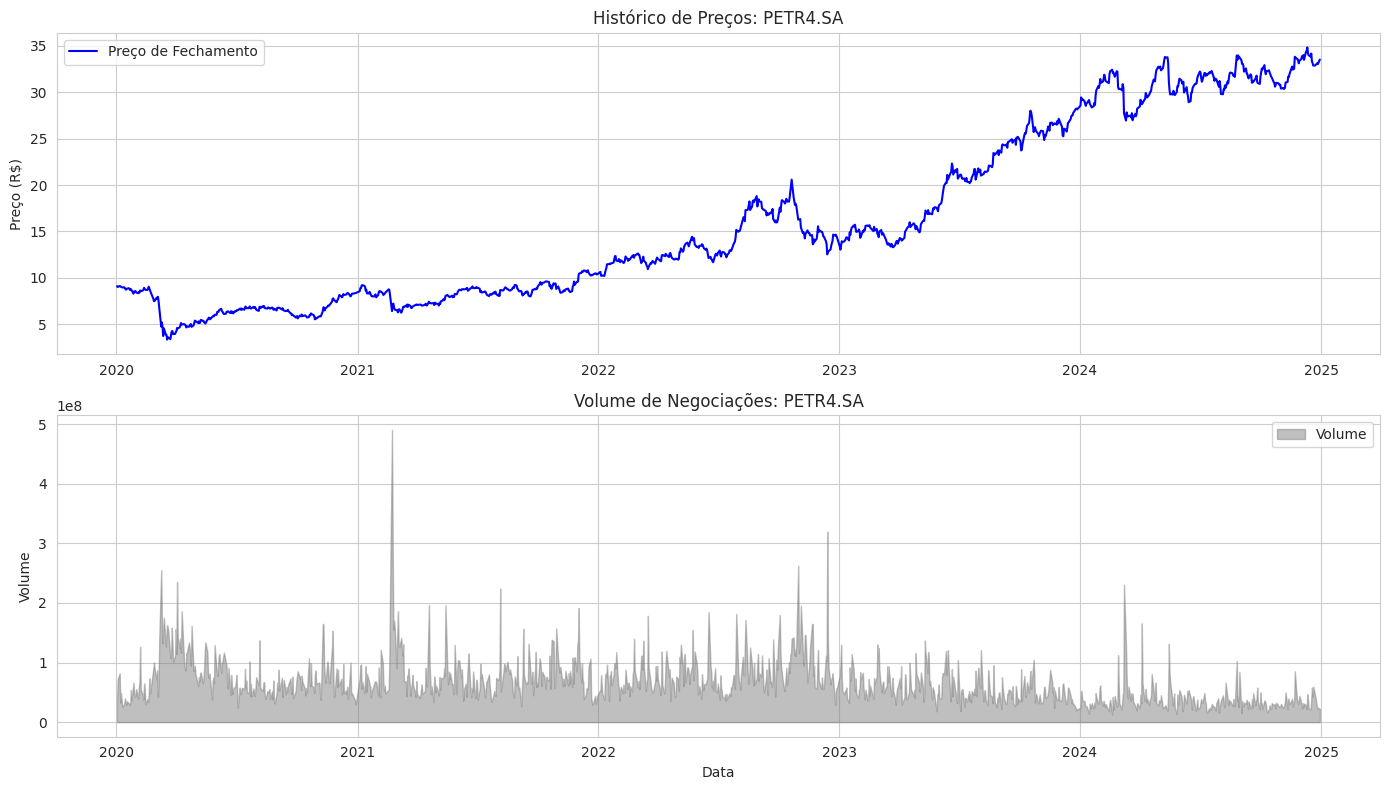

In [17]:
# 1. Instalação da biblioteca yfinance
!pip install yfinance --quiet

# 2. Importação das bibliotecas
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# CONFIGURAÇÃO
ticker = "PETR4.SA"
inicio = "2020-01-01"
fim = "2024-12-31"

# 3. Baixando os dados
print(f"Baixando dados para: {ticker}...")
dados = yf.download(ticker, start=inicio, end=fim)

# CORREÇÃO DO ERRO (FIX)
# Se os dados vierem com MultiIndex (duas linhas de cabeçalho), removemos a segunda
if isinstance(dados.columns, pd.MultiIndex):
    dados.columns = dados.columns.droplevel(1)

# 4. Visualizando as primeiras linhas
print("\nPrimeiras 5 linhas dos dados (Estrutura Corrigida):")
print(dados.head())

# 5. Criando Gráficos Simples
plt.figure(figsize=(14, 8))

# Garantir que Volume é numérico (previne erro de dados em branco)
dados['Volume'] = pd.to_numeric(dados['Volume'], errors='coerce')

# Gráfico 1: Preço de Fechamento
plt.subplot(2, 1, 1)
plt.plot(dados.index, dados['Close'], label='Preço de Fechamento', color='blue')
plt.title(f'Histórico de Preços: {ticker}')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)

# Gráfico 2: Volume de Negociações (CORRIGIDO)
plt.subplot(2, 1, 2)
# Usamos fill_between ao invés de bar. É mais leve e visível para muitos dados.
plt.fill_between(dados.index, dados['Volume'], color='grey', alpha=0.5, label='Volume')
plt.title(f'Volume de Negociações: {ticker}')
plt.ylabel('Volume')
plt.xlabel('Data')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Estatísticas Descritivas
Price        Close         High          Low         Open        Volume
count  1244.000000  1244.000000  1244.000000  1244.000000  1.244000e+03
mean     16.106636    16.320179    15.888865    16.102952  6.614914e+07
std       9.288932     9.359559     9.216658     9.284377  3.794661e+07
min       3.344523     3.608174     3.214178     3.279350  1.282670e+07
25%       8.355210     8.483714     8.279201     8.396444  4.031825e+07
50%      13.332484    13.523452    13.026732    13.273892  5.787015e+07
75%      24.862769    25.137366    24.670008    24.770025  8.128058e+07
max      34.830193    34.976068    34.418311    34.624248  4.902304e+08

-Verificação de Dados Ausentes (Null)
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


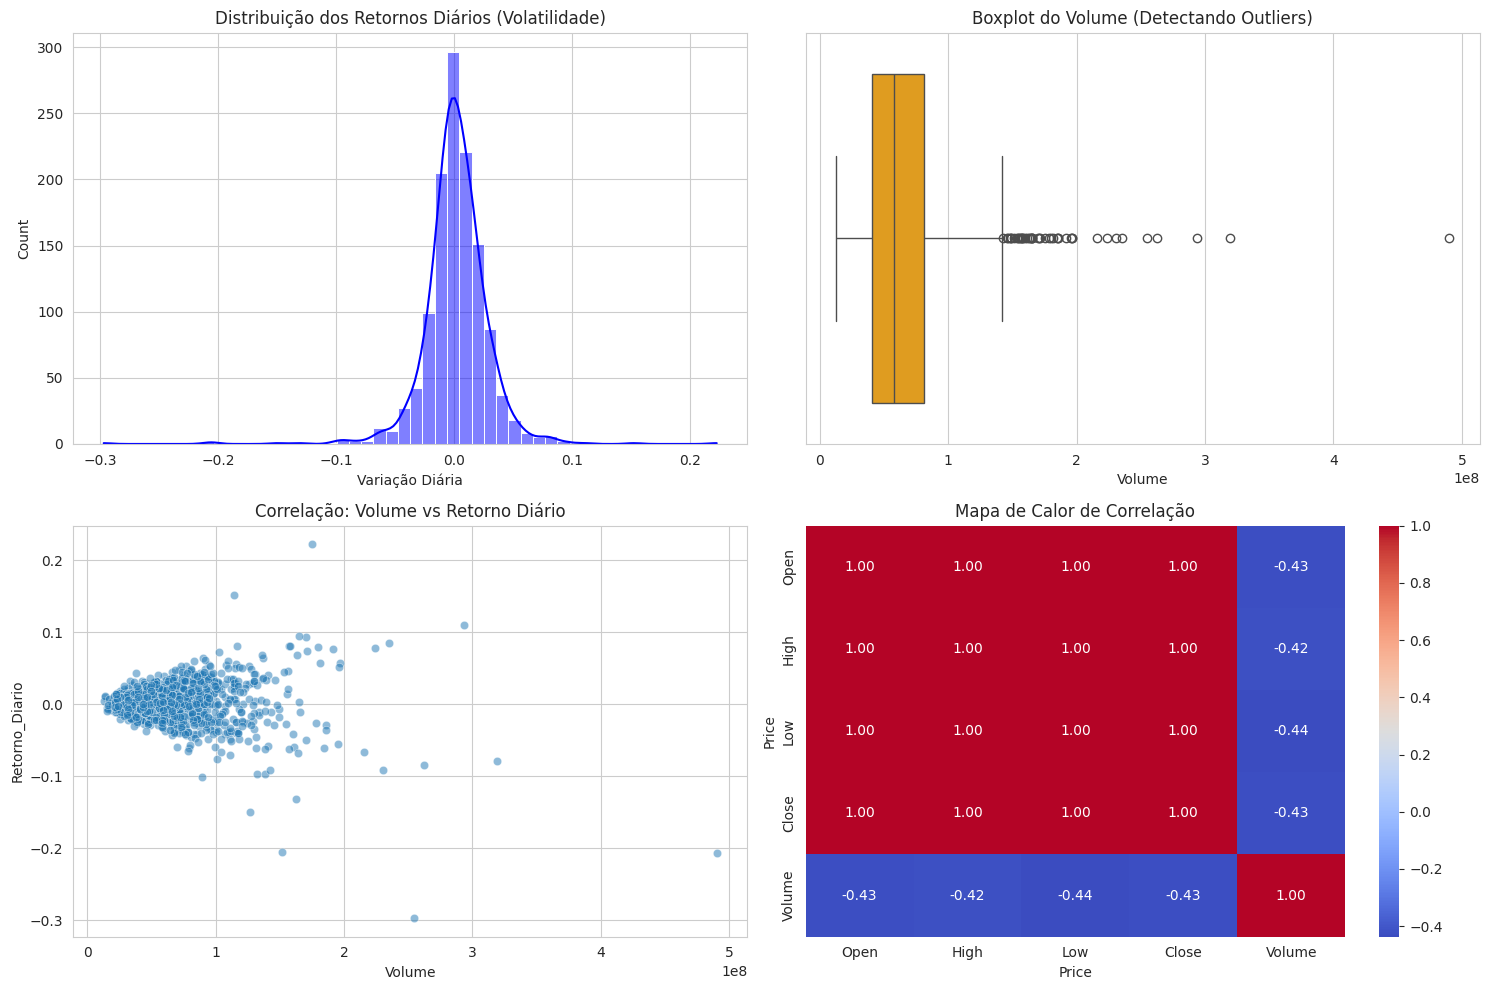

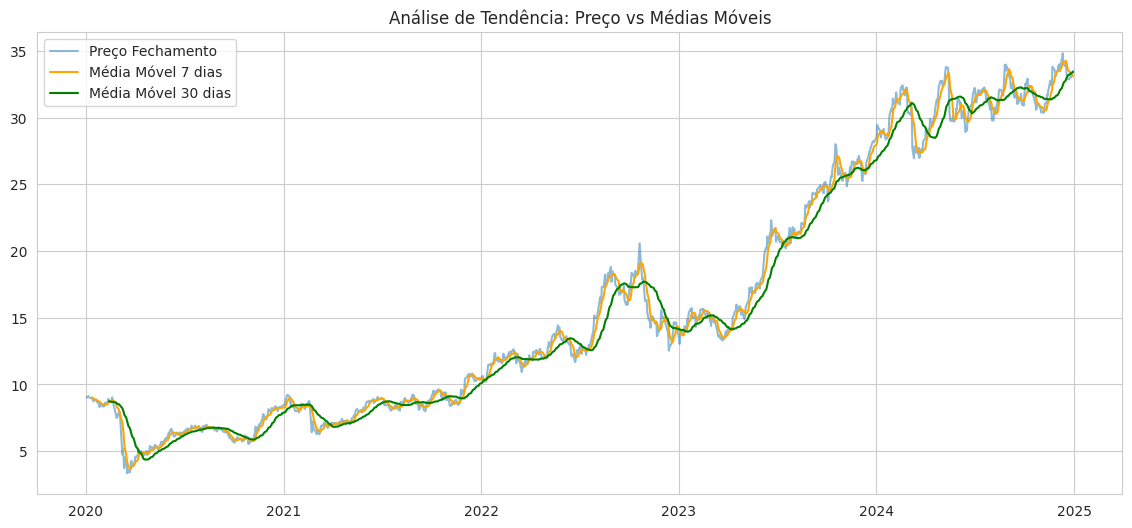

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração de estilo para os gráficos
sns.set_style("whitegrid")

# 1. ESTATÍSTICAS DESCRITIVAS E DADOS AUSENTES
print("Estatísticas Descritivas")
print(dados.describe())

print("\n-Verificação de Dados Ausentes (Null)")
print(dados.isnull().sum())

# 2. ENGENHARIA DE FEATURES SIMPLES
# Criando o 'Retorno Diário' (variação %)
dados['Retorno_Diario'] = dados['Close'].pct_change()
dados.dropna(inplace=True) # Remove a primeira linha vazia

# 3. VISUALIZAÇÃO DE DISTRIBUIÇÕES E OUTLIERS
plt.figure(figsize=(15, 10))

# A: Histograma dos Retornos
plt.subplot(2, 2, 1)
sns.histplot(dados['Retorno_Diario'], bins=50, kde=True, color='blue')
plt.title('Distribuição dos Retornos Diários (Volatilidade)')
plt.xlabel('Variação Diária')

# B: Boxplot para identificar Outliers no Volume
plt.subplot(2, 2, 2)
sns.boxplot(x=dados['Volume'], color='orange')
plt.title('Boxplot do Volume (Detectando Outliers)')

# C: Gráfico de Dispersão (Scatter Plot)
plt.subplot(2, 2, 3)
sns.scatterplot(x=dados['Volume'], y=dados['Retorno_Diario'], alpha=0.5)
plt.title('Correlação: Volume vs Retorno Diário')

# 4. CORRELAÇÕES (HEATMAP)
plt.subplot(2, 2, 4)

# CORREÇÃO AQUI
# Removemos 'Adj Close' da lista, pois ela não existe mais no dataset
colunas_para_correlacao = ['Open', 'High', 'Low', 'Close', 'Volume']
correlacao = dados[colunas_para_correlacao].corr()

sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlação')

plt.tight_layout()
plt.show()

# 5. PADRÕES TEMPORAIS
plt.figure(figsize=(14, 6))
plt.plot(dados['Close'], label='Preço Fechamento', alpha=0.5)
plt.plot(dados['Close'].rolling(window=7).mean(), label='Média Móvel 7 dias', color='orange')
plt.plot(dados['Close'].rolling(window=30).mean(), label='Média Móvel 30 dias', color='green')
plt.title('Análise de Tendência: Preço vs Médias Móveis')
plt.legend()
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. ENGENHARIA DE ATRIBUTOS (Feature Engineering)
# Vamos criar indicadores técnicos que ajudam o modelo a entender tendências.

# Média Móvel Simples (7 e 21 dias) - Ajuda a identificar a tendência de curto prazo
dados['MA7'] = dados['Close'].rolling(window=7).mean()
dados['MA21'] = dados['Close'].rolling(window=21).mean()

# Volatilidade (Desvio padrão móvel de 7 dias)
dados['Volatilidade'] = dados['Close'].rolling(window=7).std()

# RSI (Índice de Força Relativa) - Simplificado
delta = dados['Close'].diff()
ganho = (delta.where(delta > 0, 0)).rolling(window=14).mean()
perda = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = ganho / perda
dados['RSI'] = 100 - (100 / (1 + rs))

# Momentum (Diferença entre o preço de hoje e de 5 dias atrás)
dados['Momentum'] = dados['Close'] - dados['Close'].shift(5)

# 2. TRATAMENTO DE MISSING VALUES
# As médias móveis e shifts criam valores nulos (NaN) nas primeiras linhas.
# Como não podemos "inventar" esses dados históricos, nós os removemos.
dados.dropna(inplace=True)

print(f"Dados após limpeza: {dados.shape}")

# 3. PREPARAÇÃO DO TARGET (O ALVO)
# Queremos prever o preço de FECHAMENTO do dia SEGUINTE.
# Criamos uma coluna 'Target' que é simplesmente o 'Close' deslocado uma casa para trás.
dados['Target'] = dados['Close'].shift(-1)

# Removemos a última linha, pois ela não tem o "dia seguinte" para servir de resposta (Target)
dados.dropna(inplace=True)

# Selecionamos as colunas que serão usadas para prever (Features) e o Alvo
features = ['Close', 'Volume', 'MA7', 'MA21', 'Volatilidade', 'RSI', 'Momentum']
target = 'Target'

X = dados[features]
y = dados[target]

# 4. DIVISÃO TREINO E TESTE (SEM EMBARALHAR!)
# Em séries temporais, o treino deve ser ANTES do teste cronologicamente.
split_index = int(len(dados) * 0.8) # 80% para treino

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# 5. NORMALIZAÇÃO (SCALING)
# Redes Neurais e Regressões funcionam melhor com dados entre 0 e 1.
# IMPORTANTE: O scaler deve aprender APENAS com os dados de treino para evitar vazamento de dados (Data Leakage).

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Ajustamos o scaler no treino e transformamos treino e teste
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# O target é um vetor 1D, precisamos dar reshape para o scaler aceitar (-1, 1)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# VERIFICAÇÃO FINAL
print(f"\nShape Treino (X): {X_train_scaled.shape}")
print(f"Shape Teste (X): {X_test_scaled.shape}")
print("Divisão temporal feita com sucesso. Dados normalizados entre 0 e 1.")

# Mostrando um exemplo de como ficaram os dados normalizados
print("\nExemplo da primeira linha de treino normalizada:")
print(X_train_scaled[0])

Dados após limpeza: (1223, 11)

Shape Treino (X): (977, 7)
Shape Teste (X): (245, 7)
Divisão temporal feita com sucesso. Dados normalizados entre 0 e 1.

Exemplo da primeira linha de treino normalizada:
[0.1947235  0.07934217 0.19433033 0.19972788 0.07954925 0.25882362
 0.54772688]


--- Linear Regression ---
MAE (Erro Médio Absoluto): R$ 0.35
RMSE (Raiz do Erro Quadrático): R$ 0.50
R² (Coeficiente de Determinação): 0.9115

Otimizando SVR (Isso pode demorar um pouco)...
Melhores parâmetros SVR: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
--- SVR (Otimizado) ---
MAE (Erro Médio Absoluto): R$ 2.48
RMSE (Raiz do Erro Quadrático): R$ 2.54
R² (Coeficiente de Determinação): -1.3268

Melhores parâmetros Tree: {'max_depth': 5, 'min_samples_split': 2}
--- Decision Tree ---
MAE (Erro Médio Absoluto): R$ 2.60
RMSE (Raiz do Erro Quadrático): R$ 2.94
R² (Coeficiente de Determinação): -2.1151


=== TABELA COMPARATIVA ===
                        MAE      RMSE        R2
Modelo                                         
Linear Regression  0.352027  0.495991  0.911548
SVR (Otimizado)    2.480275  2.543876 -1.326760
Decision Tree      2.595640  2.943450 -2.115109


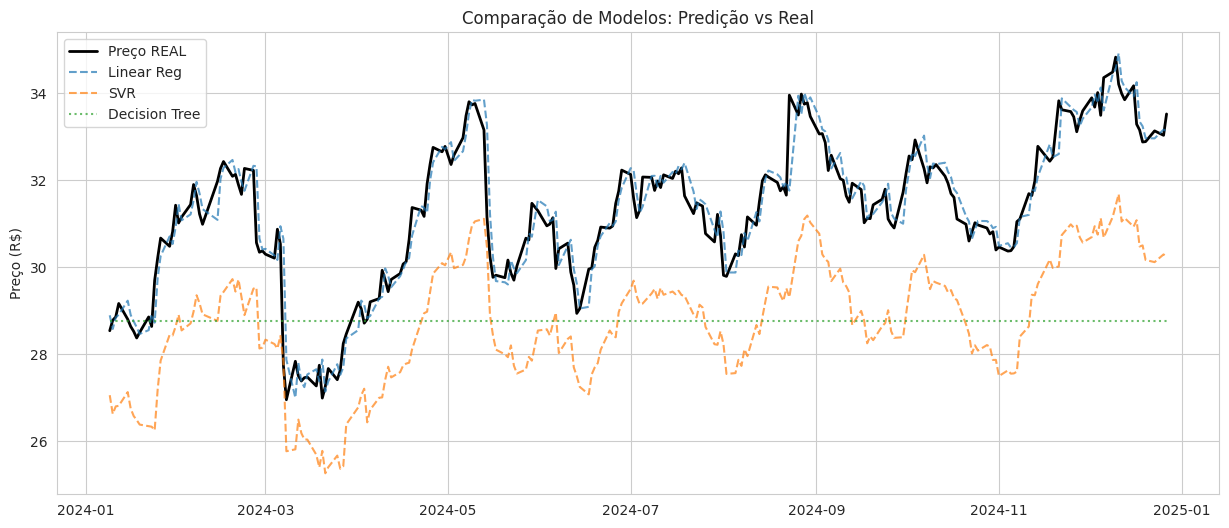

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# FUNÇÃO AUXILIAR PARA AVALIAÇÃO
def avaliar_modelo(nome, y_true, y_pred, scaler):
    # Desfazemos a escala (inverse_transform) para ver o erro em Reais (R$)
    y_true_real = scaler.inverse_transform(y_true.reshape(-1, 1))
    y_pred_real = scaler.inverse_transform(y_pred.reshape(-1, 1))

    mae = mean_absolute_error(y_true_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    r2 = r2_score(y_true_real, y_pred_real)

    print(f"--- {nome} ---")
    print(f"MAE (Erro Médio Absoluto): R$ {mae:.2f}")
    print(f"RMSE (Raiz do Erro Quadrático): R$ {rmse:.2f}")
    print(f"R² (Coeficiente de Determinação): {r2:.4f}\n")

    return {'Modelo': nome, 'MAE': mae, 'RMSE': rmse, 'R2': r2}, y_pred_real

results_list = []
predictions = {}


# 1. REGRESSÃO LINEAR (Baseline)

# É o modelo mais simples. Serve para saber se os modelos complexos estão valendo a pena.
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_scaled.ravel())

y_pred_lr = lr_model.predict(X_test_scaled)
res_lr, pred_lr_real = avaliar_modelo("Linear Regression", y_test_scaled, y_pred_lr, scaler_y)
results_list.append(res_lr)
predictions['Linear Regression'] = pred_lr_real


# 2. SVR - SUPPORT VECTOR REGRESSOR (Com Ajuste de Hiperparâmetros)

# O SVR precisa de ajuste fino. Vamos usar GridSearchCV para achar o melhor 'C' e 'gamma'.
# Usamos TimeSeriesSplit para não misturar futuro com passado na validação.

print("Otimizando SVR (Isso pode demorar um pouco)...")
parameters = {
    'kernel': ['rbf'],
    'C': [1, 10, 100],
    'gamma': ['scale', 0.1, 0.01]
}

tscv = TimeSeriesSplit(n_splits=3)
svr = SVR()
grid_svr = GridSearchCV(svr, parameters, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train_scaled, y_train_scaled.ravel())

print(f"Melhores parâmetros SVR: {grid_svr.best_params_}")

best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
res_svr, pred_svr_real = avaliar_modelo("SVR (Otimizado)", y_test_scaled, y_pred_svr, scaler_y)
results_list.append(res_svr)
predictions['SVR'] = pred_svr_real


# 3. DECISION TREE REGRESSOR

# Árvores tendem a "overfitar" (decorar) muito rápido. Vamos limitar a profundidade.
tree_params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}

grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=42), tree_params, cv=tscv, scoring='neg_mean_squared_error')
grid_tree.fit(X_train_scaled, y_train_scaled.ravel())

print(f"Melhores parâmetros Tree: {grid_tree.best_params_}")

best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test_scaled)
res_tree, pred_tree_real = avaliar_modelo("Decision Tree", y_test_scaled, y_pred_tree, scaler_y)
results_list.append(res_tree)
predictions['Decision Tree'] = pred_tree_real

# 4. COMPARAÇÃO FINAL E GRÁFICO

df_resultados = pd.DataFrame(results_list).set_index('Modelo')
print("\n=== TABELA COMPARATIVA ===")
print(df_resultados)

# Plotando os resultados
plt.figure(figsize=(15, 6))

# Dados Reais (convertendo de volta para R$)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

plt.plot(y_test.index, y_test_real, label='Preço REAL', color='black', linewidth=2)
plt.plot(y_test.index, predictions['Linear Regression'], label='Linear Reg', linestyle='--', alpha=0.7)
plt.plot(y_test.index, predictions['SVR'], label='SVR', linestyle='--', alpha=0.7)
plt.plot(y_test.index, predictions['Decision Tree'], label='Decision Tree', linestyle=':', alpha=0.7)

plt.title('Comparação de Modelos: Predição vs Real')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)
plt.show()

--- ANÁLISE DE OVERFITTING E REGULARIZAÇÃO ---
Quanto menor o 'Gap', mais estável é o modelo.


,Modelo,RMSE Treino,RMSE Teste,Gap (Overfitting)
0,Linear Regression (Sem Reg),0.012590,0.018999,0.006409
1,Ridge (L2) - Alpha=1.0,0.013399,0.020008,0.006609
2,Lasso (L1) - Alpha=0.01,0.048425,0.116246,0.067822
3,ElasticNet,0.033636,0.076037,0.042401
4,Árvore (Sem Limites),0.000000,0.108928,0.108928
5,Árvore (Regularizada),0.013492,0.115923,0.102431


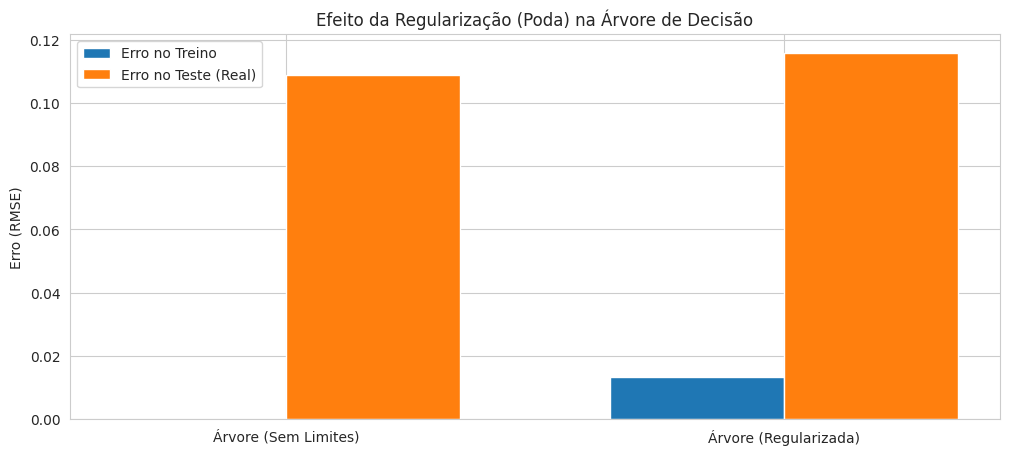

In [21]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

# Lista para guardar os resultados
results_reg = []

def calcular_metricas(nome_modelo, modelo, X_train, y_train, X_test, y_test):
    # Treina o modelo
    modelo.fit(X_train, y_train.ravel())

    # Previsões
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    # Cálculo do RMSE (Erro Quadrático Médio)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Diferença (Gap) - Quanto maior, maior o Overfitting
    gap = rmse_test - rmse_train

    return {
        'Modelo': nome_modelo,
        'RMSE Treino': rmse_train, # Erro no que ele já viu
        'RMSE Teste': rmse_test,   # Erro no futuro (o que importa)
        'Gap (Overfitting)': gap
    }

# 1. MODELOS LINEARES COM REGULARIZAÇÃO

# A) Regressão Linear Pura (Sem regularização)
results_reg.append(calcular_metricas(
    "Linear Regression (Sem Reg)",
    LinearRegression(),
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
))

# B) Ridge (Regularização L2) - Ótimo para lidar com multicolinearidade
# Alpha controla a força da penalidade. Alpha=1.0 é padrão.
results_reg.append(calcular_metricas(
    "Ridge (L2) - Alpha=1.0",
    Ridge(alpha=1.0),
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
))

# C) Lasso (Regularização L1) - Tende a zerar coeficientes inúteis (Feature Selection)
results_reg.append(calcular_metricas(
    "Lasso (L1) - Alpha=0.01",
    Lasso(alpha=0.01), # Alpha menor pois Lasso é agressivo
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
))

# D) ElasticNet (Mistura L1 e L2)
results_reg.append(calcular_metricas(
    "ElasticNet",
    ElasticNet(alpha=0.01, l1_ratio=0.5),
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
))

# 2. ÁRVORES DE DECISÃO E PRUNING (PODA)

# A) Árvore "Viciada" (Overfitted)
# Deixamos a profundidade livre (None). Ela vai decorar cada ruído do treino.
tree_overfit = DecisionTreeRegressor(max_depth=None, random_state=42)
results_reg.append(calcular_metricas(
    "Árvore (Sem Limites)",
    tree_overfit,
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
))

# B) Árvore Regularizada (Pruning/Poda)
# Limitamos a profundidade (max_depth) e exigimos mínimo de amostras nas folhas
tree_pruned = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)
results_reg.append(calcular_metricas(
    "Árvore (Regularizada)",
    tree_pruned,
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
))

#3. EXIBINDO OS RESULTADOS
df_analise = pd.DataFrame(results_reg)
print("--- ANÁLISE DE OVERFITTING E REGULARIZAÇÃO ---")
print("Quanto menor o 'Gap', mais estável é o modelo.")
display(df_analise)

#Visualização Gráfica do Efeito na Árvore
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
modelos_tree = df_analise[df_analise['Modelo'].str.contains("Árvore")]

x = np.arange(len(modelos_tree))
width = 0.35

plt.bar(x - width/2, modelos_tree['RMSE Treino'], width, label='Erro no Treino')
plt.bar(x + width/2, modelos_tree['RMSE Teste'], width, label='Erro no Teste (Real)')

plt.xticks(x, modelos_tree['Modelo'])
plt.ylabel('Erro (RMSE)')
plt.title('Efeito da Regularização (Poda) na Árvore de Decisão')
plt.legend()
plt.show()

--- INTERPRETAÇÃO DOS MODELOS ---


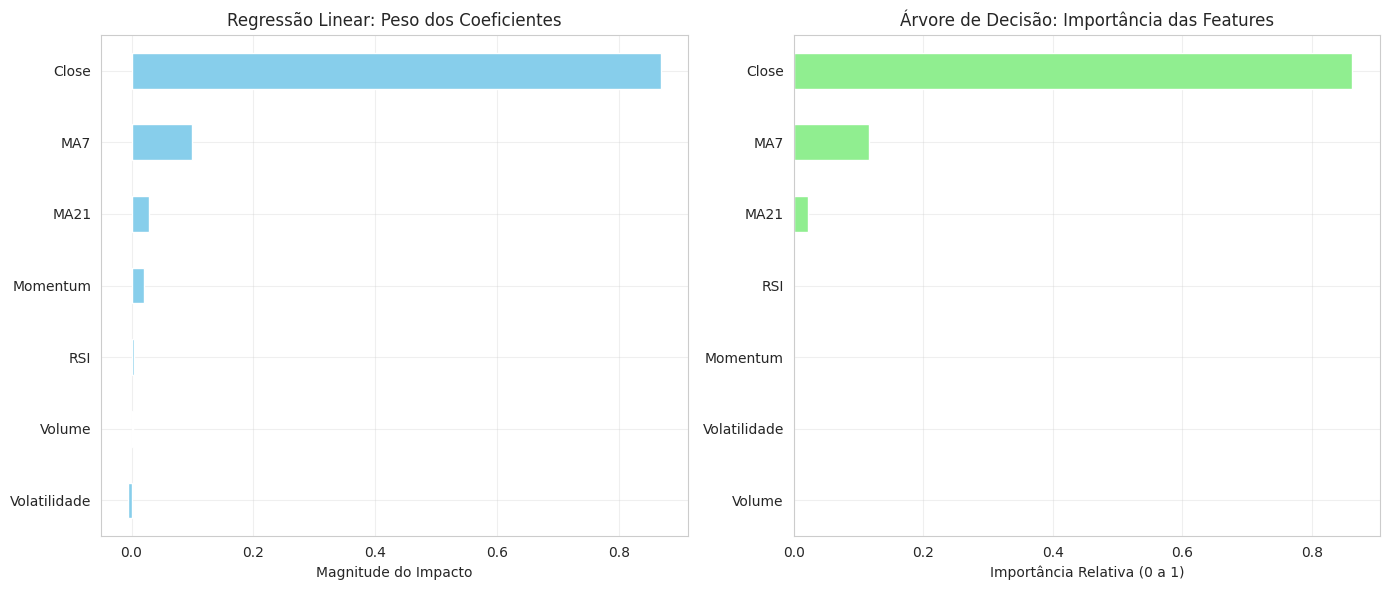


--- RESUMO DA INTERPRETAÇÃO ---
1. Regressão Linear:
Close           0.869053
MA7             0.098810
MA21            0.029282
Momentum        0.020782
RSI             0.003338
Volume          0.002358
Volatilidade   -0.006232
dtype: float64

2. Árvore de Decisão:
Close           0.862189
MA7             0.116030
MA21            0.021651
RSI             0.000067
Momentum        0.000064
Volume          0.000000
Volatilidade    0.000000
dtype: float64


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Certifique-se de que os modelos (lr_model, best_tree) e as variáveis (X, features)
# já estejam definidos das células anteriores.

print("--- INTERPRETAÇÃO DOS MODELOS ---")

plt.figure(figsize=(14, 6))

# 1. IMPORTÂNCIA NA REGRESSÃO LINEAR (Coeficientes)
# A magnitude dos coeficientes indica o impacto direto na previsão.
plt.subplot(1, 2, 1)
coeficientes = pd.Series(lr_model.coef_, index=features)
coeficientes.sort_values().plot(kind='barh', color='skyblue')
plt.title('Regressão Linear: Peso dos Coeficientes')
plt.xlabel('Magnitude do Impacto')
plt.grid(True, alpha=0.3)

# 2. IMPORTÂNCIA NA ÁRVORE DE DECISÃO
# Mostra quais features foram mais usadas para "quebrar" os nós da árvore (reduzir impureza).
plt.subplot(1, 2, 2)
# Usaremos 'best_tree' se definido, senão a árvore padrão
modelo_arvore = best_tree if 'best_tree' in locals() else tree_pruned
importancia = pd.Series(modelo_arvore.feature_importances_, index=features)
importancia.sort_values().plot(kind='barh', color='lightgreen')
plt.title('Árvore de Decisão: Importância das Features')
plt.xlabel('Importância Relativa (0 a 1)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- DISCUSSÃO TEXTUAL ---
print("\n--- RESUMO DA INTERPRETAÇÃO ---")
print("1. Regressão Linear:")
print(coeficientes.sort_values(ascending=False))
print("\n2. Árvore de Decisão:")
print(importancia.sort_values(ascending=False))

Lembrando a importancia de instalar o STREAMLIT pois o mesmo não vem por padrao no google colab
Para isso siga esse passo a passo

1-Instale o Streamlit e o localtunnel:
!pip install streamlit -q
!npm install localtunnel

2-Salve o código em um arquivo dentro do Colab:
%%writefile app_acoes.py

3-Inicie o servidor e gere o link de acesso:
!streamlit run app_acoes.py &>/content/logs.txt & npx localtunnel --port 8501

In [25]:
import streamlit as st
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# --- CONFIGURAÇÃO DA PÁGINA ---
st.set_page_config(page_title="Predição de Ações - ML Demo", layout="wide")

st.title("📈 Dashboard de Predição de Ações com Machine Learning")
st.markdown("""
Esta aplicação demonstra o pipeline completo de um projeto de Data Science:
**Coleta de Dados** -> **Engenharia de Features** -> **Modelagem** -> **Avaliação**.
""")

# --- BARRA LATERAL (INPUTS) ---
st.sidebar.header("Configurações")
ticker = st.sidebar.text_input("Ticker da Ação (Yahoo Finance)", value="PETR4.SA")
data_inicio = st.sidebar.date_input("Data de Início", value=date.today() - timedelta(days=365*4))
data_fim = st.sidebar.date_input("Data Final", value=date.today())

# --- FUNÇÕES AUXILIARES (CACHED) ---
@st.cache_data
def carregar_dados(ticker, inicio, fim):
    try:
        # Baixa os dados
        df = yf.download(ticker, start=inicio, end=fim)

        # Correção do Bug do Yfinance (MultiIndex)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        df.dropna(inplace=True)
        return df
    except Exception as e:
        st.error(f"Erro ao carregar dados: {e}")
        return None

def criar_features(df):
    df_ml = df.copy()

    # Médias Móveis
    df_ml['MA7'] = df_ml['Close'].rolling(window=7).mean()
    df_ml['MA21'] = df_ml['Close'].rolling(window=21).mean()

    # Volatilidade
    df_ml['Volatilidade'] = df_ml['Close'].rolling(window=7).std()

    # RSI (Índice de Força Relativa)
    delta = df_ml['Close'].diff()
    ganho = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    perda = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = ganho / perda
    df_ml['RSI'] = 100 - (100 / (1 + rs))

    # Target (Preço de amanhã)
    df_ml['Target'] = df_ml['Close'].shift(-1)

    df_ml.dropna(inplace=True)
    return df_ml

# --- CARREGAMENTO ---
dados = carregar_dados(ticker, data_inicio, data_fim)

if dados is not None and len(dados) > 0:

    # Abas da Aplicação
    tab1, tab2, tab3 = st.tabs(["📊 Análise Exploratória", "🤖 Modelagem & Predição", "ℹ️ Sobre o Projeto"])

    # --- ABA 1: EDA ---
    with tab1:
        col1, col2 = st.columns([3, 1])

        with col1:
            st.subheader(f"Evolução do Preço: {ticker}")
            # Gráfico Interativo com Plotly
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=dados.index, y=dados['Close'], mode='lines', name='Fechamento'))
            fig.add_trace(go.Scatter(x=dados.index, y=dados['Close'].rolling(30).mean(), mode='lines', name='Média 30d', line=dict(dash='dash')))
            st.plotly_chart(fig, use_container_width=True)

        with col2:
            st.subheader("Estatísticas")
            st.write(dados[['Close', 'Volume']].describe())

        st.subheader("Volume de Negociações")
        st.bar_chart(dados['Volume'])

    # --- ABA 2: MODELAGEM ---
    with tab2:
        st.write("### Treinamento do Modelo")

        # Preparação
        dados_ml = criar_features(dados)
        features = ['Close', 'MA7', 'MA21', 'RSI', 'Volatilidade']
        target = 'Target'

        X = dados_ml[features]
        y = dados_ml[target]

        # Split (Sequencial)
        split_idx = int(len(dados_ml) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Normalização
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Seleção de Modelo
        modelo_escolhido = st.selectbox(
            "Escolha o Algoritmo:",
            ["Regressão Linear", "Ridge Regression (L2)", "Decision Tree (Regularizada)"]
        )

        # Treinamento
        if modelo_escolhido == "Regressão Linear":
            model = LinearRegression()
        elif modelo_escolhido == "Ridge Regression (L2)":
            model = Ridge(alpha=1.0)
        else:
            model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

        model.fit(X_train_scaled, y_train)
        prediction = model.predict(X_test_scaled)

        # Métricas
        mae = mean_absolute_error(y_test, prediction)
        rmse = np.sqrt(mean_squared_error(y_test, prediction))
        r2 = r2_score(y_test, prediction)

        # Exibição de Resultados
        col_res1, col_res2, col_res3 = st.columns(3)
        col_res1.metric("MAE (Erro Médio)", f"R$ {mae:.2f}")
        col_res2.metric("RMSE", f"R$ {rmse:.2f}")
        col_res3.metric("R² Score", f"{r2:.4f}")

        # Gráfico Comparativo
        st.subheader("Comparação: Real vs Predito (Conjunto de Teste)")
        fig_pred = go.Figure()

        # Dados Reais
        fig_pred.add_trace(go.Scatter(
            x=y_test.index, y=y_test, mode='lines', name='Real', line=dict(color='blue')
        ))

        # Predição
        fig_pred.add_trace(go.Scatter(
            x=y_test.index, y=prediction, mode='lines', name='Predito pelo Modelo', line=dict(color='red', dash='dot')
        ))

        st.plotly_chart(fig_pred, use_container_width=True)

        # Feature Importance (Apenas para Árvore e Linear)
        if modelo_escolhido == "Regressão Linear" or "Ridge" in modelo_escolhido:
            st.info("💡 Nota: Modelos lineares tendem a seguir a tendência, mas podem ter um 'atraso' (lag) em relação a movimentos bruscos.")

    # --- ABA 3: SOBRE ---
    with tab3:
        st.header("Detalhes do Projeto")
        st.markdown("""
        **Objetivo:** Prever o preço de fechamento (Close) de uma ação no dia seguinte (t+1).

        **Metodologia:**
        1.  **Coleta:** Dados diários via Yahoo Finance API.
        2.  **Features:** * *Médias Móveis (7 e 21 dias)*: Capturam a tendência de curto prazo.
            * *RSI*: Indica sobrecompra ou sobrevenda.
            * *Volatilidade*: Mede o risco recente.
        3.  **Split:** Divisão temporal (Treino: Primeiros 80% / Teste: Últimos 20%) para evitar data leakage.
        4.  **Avaliação:** Métricas de erro (RMSE) e ajuste (R²).

        **Filipe arthur matheus** Projeto Final de Machine Learning.
        """)

else:
    st.warning("Nenhum dado encontrado. Verifique o Ticker digitado.")

ModuleNotFoundError: No module named 'streamlit'